In [ ]:
%pip install yfinance --upgrade --no-cache-dir

In [ ]:
%pip install finta

In [360]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from finta import TA

In [361]:
stock = 'NVDA'

nvidia = yf.Ticker(stock)
nvidia = nvidia.history(period='max')

nvidia

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.0,0.0
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.0,0.0
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.0,0.0
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.0,0.0
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-11-16 00:00:00-05:00,161.619995,163.619995,158.729996,159.100006,64954700.0,0.0,0.0
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,0.0,0.0
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,0.0,0.0


In [362]:
nvidia.index

DatetimeIndex(['1999-01-22 00:00:00-05:00', '1999-01-25 00:00:00-05:00',
               '1999-01-26 00:00:00-05:00', '1999-01-27 00:00:00-05:00',
               '1999-01-28 00:00:00-05:00', '1999-01-29 00:00:00-05:00',
               '1999-02-01 00:00:00-05:00', '1999-02-02 00:00:00-05:00',
               '1999-02-03 00:00:00-05:00', '1999-02-04 00:00:00-05:00',
               ...
               '2022-11-09 00:00:00-05:00', '2022-11-10 00:00:00-05:00',
               '2022-11-11 00:00:00-05:00', '2022-11-14 00:00:00-05:00',
               '2022-11-15 00:00:00-05:00', '2022-11-16 00:00:00-05:00',
               '2022-11-17 00:00:00-05:00', '2022-11-18 00:00:00-05:00',
               '2022-11-21 00:00:00-05:00', '2022-11-22 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=6001, freq=None)

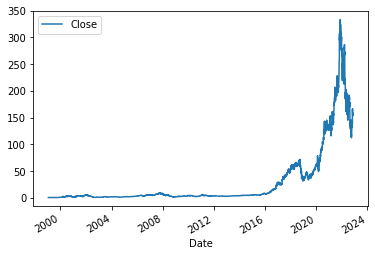

In [363]:
nvidia.plot.line(y='Close', use_index=True)

In [364]:
del nvidia['Dividends']
del nvidia['Stock Splits']

In [365]:
nvidia['t1'] = nvidia['Close'].shift(-1)

In [366]:
nvidia

,Open,High,Low,Close,Volume,t1
Date,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370
...,...,...,...,...,...,...
2022-11-16 00:00:00-05:00,161.619995,163.619995,158.729996,159.100006,64954700.0,156.770004
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,154.089996
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998


In [367]:
nvidia['Target'] = (nvidia['t1'] > nvidia['Close']).astype(int)

In [310]:
nvidia

,Open,High,Low,Close,Volume,t1,Target
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963,1
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690,0
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495,0
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300,0
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370,0
...,...,...,...,...,...,...,...
2022-11-16 00:00:00-05:00,161.619995,163.619995,158.729996,159.100006,64954700.0,156.770004,0
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,154.089996,0
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998,0


In [368]:
def smooth_data(data, alpha):
  return data.ewm(alpha=alpha).mean()

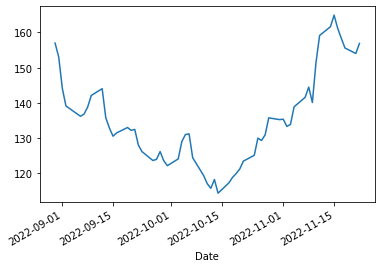

In [369]:
alpha = 0.65
data = smooth_data(nvidia, alpha)

smooth_trend = data.iloc[-60:]
smooth_trend['Close'].plot()

In [370]:
data.rename(columns = {'Close': 'close', 'High': 'high', 'Low': 'low', 
                       'Adj Close': 'adj close', 'Volume': 'volume', 'Open': 'open'}, 
            inplace = True)

In [264]:
indicators = ['RSI', 'STOCH', 'ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV']

In [371]:
indicators = ['SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'VAMA', 'ER', 'KAMA', 
             'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MOM', 'ROC', 'RSI', 'IFT_RSI']

In [372]:
for indicator in indicators:
  data[indicator] = eval('TA.' + indicator + '(data)')

In [373]:
print(data.columns)

Index(['open', 'high', 'low', 'close', 'volume', 't1', 'Target', 'SMA', 'SMM',
       'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'VAMA', 'ER', 'KAMA',
       'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MOM', 'ROC', 'RSI',
       'IFT_RSI'],
      dtype='object')


In [374]:
print(nvidia.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Target'], dtype='object')


In [375]:
to_del = ['open', 'high', 'low', 'close', 'volume', 't1', 'Target']

In [376]:
for column in to_del:
  del data[column]

In [377]:
nvidia = nvidia.merge(data, how='inner', on='Date')

In [378]:
nvidia = nvidia.fillna(0)

In [331]:
nvidia

,Open,High,Low,Close,Volume,t1,Target,SMA,SMM,SSMA,...,ZLEMA,WMA,HMA,EVWMA,VWAP,SMMA,MOM,ROC,RSI,IFT_RSI
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963,1,0.000000,0.000000,0.376518,...,0.000000,0.000000,0.000000,0.000000,0.393651,0.376518,0.000000,0.000000,0.000000,0.000000
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690,0,0.000000,0.000000,0.391987,...,0.000000,0.000000,0.000000,0.000000,0.395921,0.391303,0.000000,0.000000,100.000000,0.000000
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495,0,0.000000,0.000000,0.391530,...,0.000000,0.000000,0.000000,0.000000,0.396246,0.391119,0.000000,0.000000,64.439920,0.000000
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300,0,0.000000,0.000000,0.389690,...,0.000000,0.000000,0.000000,0.000000,0.395494,0.389613,0.000000,0.000000,56.547131,0.000000
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370,0,0.000000,0.000000,0.387942,...,0.000000,0.000000,0.000000,0.000000,0.394830,0.388161,0.000000,0.000000,53.180765,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-16 00:00:00-05:00,161.619995,163.619995,158.729996,159.100006,64954700.0,156.770004,0,131.304398,151.411761,145.548928,...,154.458215,156.180640,161.660958,139.802968,22.170805,147.197359,27.826730,19.142847,72.312782,0.823177
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,154.089996,0,131.934418,158.295058,146.965165,...,156.441092,157.547103,164.244065,140.922560,22.195983,147.461590,24.403354,16.941106,68.019938,0.778865
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998,0,132.606436,158.295058,147.920343,...,158.024934,157.935376,165.049508,141.654487,22.216227,147.654451,16.685673,16.700000,64.067135,0.685835


In [379]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from numpy.core.arrayprint import format_float_scientific
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [380]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [ ]:
# nvidia = nvidia.drop('2001-09-12 00:00:00-04:00')

In [381]:
print(nvidia.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'Target', 'SMA', 'SMM',
       'SSMA', 'EMA', 'DEMA', 'TEMA', 'TRIMA', 'TRIX', 'VAMA', 'ER', 'KAMA',
       'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MOM', 'ROC', 'RSI',
       'IFT_RSI'],
      dtype='object')


In [382]:
print(len(nvidia))

6001


In [383]:
train = nvidia.iloc[:-100]
test = nvidia.iloc[-100:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume', 't1', 'SMA', 'SMM', 'SSMA', 'EMA', 'DEMA', 
              'TEMA', 'TRIMA', 'TRIX', 'VAMA', 'ER', 'KAMA', 
             'ZLEMA', 'WMA', 'HMA', 'EVWMA', 'VWAP', 'SMMA', 'MOM', 'ROC', 'RSI', 'IFT_RSI']

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [384]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

In [385]:
precision_score(test['Target'], preds)

0.5714285714285714

In [386]:
combined = pd.concat([test['Target'], preds], axis=1)

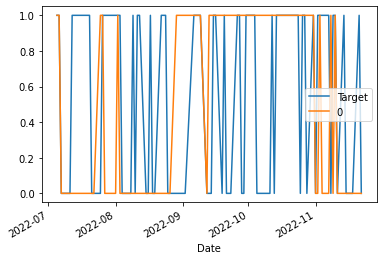

In [341]:
combined.plot()

In [387]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'], preds], axis = 1)
  return combined

In [388]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i + step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [389]:
predictions = backtest(nvidia, model, predictors)

In [345]:
predictions['Predictions'].value_counts()

0    2478
1    1023
Name: Predictions, dtype: int64

In [390]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5751196172248804

In [347]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.526421
0    0.473579
Name: Target, dtype: float64

In [391]:
horizons = [2, 5, 60, 250, 1000]

In [392]:
new_predictors = []

for horizon in horizons:
  rolling_averages = nvidia.rolling(horizon).mean()

  ratio_column = f'Close_Ratio_{horizon}'
  nvidia[ratio_column] = nvidia['Close'] / rolling_averages['Close']

  trend_column = f'Trend_{horizon}'
  nvidia[trend_column] = nvidia.shift(1).rolling(horizon).sum()['Target']

  new_predictors += [ratio_column, trend_column]

In [393]:
# nvidia = nvidia.dropna()
nvidia = nvidia.fillna(0)

In [350]:
nvidia

,Open,High,Low,Close,Volume,t1,Target,SMA,SMM,SSMA,...,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963,1,0.000000,0.000000,0.376518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690,0,0.000000,0.000000,0.391987,...,1.049774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495,0,0.000000,0.000000,0.391530,...,0.959642,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300,0,0.000000,0.000000,0.389690,...,0.998440,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370,0,0.000000,0.000000,0.387942,...,0.998435,0.0,0.982749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-16 00:00:00-05:00,161.619995,163.619995,158.729996,159.100006,64954700.0,156.770004,0,131.304398,151.411761,145.548928,...,0.976793,1.0,0.982730,3.0,1.172422,32.0,0.786105,122.0,1.246801,541.0
2022-11-17 00:00:00-05:00,157.149994,162.660004,155.350006,156.770004,71089400.0,154.089996,0,131.934418,158.295058,146.965165,...,0.992624,0.0,0.969212,2.0,1.157441,31.0,0.777247,121.0,1.227416,540.0
2022-11-18 00:00:00-05:00,159.660004,160.020004,151.199997,154.089996,49167700.0,153.169998,0,132.606436,158.295058,147.920343,...,0.991379,0.0,0.963580,1.0,1.141163,30.0,0.766471,121.0,1.205347,540.0


In [352]:
# model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [397]:
names = [
    "SVC",
    "Random Forest",
    "Ada Boost",
    "Decision Tree",
    "Quadratic Discrimination",
    "MPLC"
]

classifiers = [
    #svm.SVC(gamma=0.001, C=100., kernel='rbf', verbose=False, probability=False),
    RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1),
    AdaBoostClassifier(),
    DecisionTreeClassifier(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000)
]

In [395]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'], preds], axis = 1)
  return combined

In [402]:
accuracy = []
for model in classifiers:
  predictions = backtest(nvidia, model, new_predictors)
  accuracy.append(precision_score(predictions['Target'], predictions['Predictions']))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [403]:
print(accuracy)

[0.573170731707317, 0.0, 0.5407697325505545, 0.527651858567543, 0.5132530120481927]


Tried differnt classifiers but still fucking low -> to improve

In [354]:
predictions = backtest(nvidia, model, new_predictors)

In [399]:
predictions['Predictions'].value_counts()

0.0    2275
1.0    1226
Name: Predictions, dtype: int64

In [400]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5212071778140294